In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

# For PLotting we will use these library

import matplotlib.pyplot as plt

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [3]:

# Step 1: Data cleaning
#data = yf.download(tickers='BTC-usd', start='2014-12-31', end='2022-12-31', interval='1d')
data = yf.download(tickers='ETH-USD', period='max', interval='1d')
data.dropna(inplace=True)
data
# التأكد من الفترة التي وفرها الياهو قبل عملية تحميل البيانات لخلق ملف csv

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-02-27,23561.451172,23857.890625,23205.878906,23522.871094,23522.871094,22660763494
2023-02-28,23521.837891,23585.384766,23077.650391,23147.353516,23147.353516,20535363434
2023-03-01,23150.929688,23880.632812,23088.626953,23646.550781,23646.550781,24662841200


In [4]:
# Step 2: Feature engineering
data['RSI']       = ta.rsi(data.Close, length=15)
data['EMA_short'] = ta.ema(data.Close, length=20)
data['EMA_long']  = ta.ema(data.Close, length=100)
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Close'], axis=1, inplace=True)
# Setting the index
data.set_index('Date', inplace=True)

# Dropping any NaNs
data.dropna(inplace=True)

data.info()
data.tail(10)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2991 entries, 2014-12-25 to 2023-03-03
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2991 non-null   float64
 1   High       2991 non-null   float64
 2   Low        2991 non-null   float64
 3   Adj Close  2991 non-null   float64
 4   Volume     2991 non-null   int64  
 5   RSI        2991 non-null   float64
 6   EMA_short  2991 non-null   float64
 7   EMA_long   2991 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 210.3 KB


,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,
2023-02-22,24437.417969,24472.339844,23644.318359,24188.843750,30199996781,59.849305,23432.405984,20797.941721
2023-02-23,24190.718750,24572.089844,23693.919922,23947.492188,30476264066,57.593464,23481.461813,20860.309057
2023-02-24,23946.007812,24103.705078,23007.072266,23198.126953,26811744928,51.176539,23454.477541,20906.602481
2023-02-25,23200.125000,23210.210938,22861.558594,23175.375000,16100721565,50.991722,23427.896346,20951.528669
2023-02-26,23174.150391,23654.367188,23084.220703,23561.212891,16644534842,54.009507,23440.593160,21003.205585
2023-02-27,23561.451172,23857.890625,23205.878906,23522.871094,22660763494,53.657719,23448.429154,21053.099951
2023-02-28,23521.837891,23585.384766,23077.650391,23147.353516,20535363434,50.224893,23419.755283,21094.570319
2023-03-01,23150.929688,23880.632812,23088.626953,23646.550781,24662841200,54.381735,23441.354855,21145.104585
2023-03-02,23647.019531,23739.138672,23245.021484,23475.466797,20386398516,52.763703,23444.603611,21191.250372


In [ ]:
data= data.to_csv('ETH_case1.csv')

In [5]:
from datetime import datetime

def date_parser(date_str):
    date_obj = datetime.strptime(date_str, '%m/%d/%Y')
    return date_obj.strftime('%m-%d-%Y')


In [6]:
data_csv = pd.read_csv('ETH_case1.csv', parse_dates=['Date'], date_parser=date_parser)
data_csv.dropna(inplace=True)
# Setting the index

data_csv.set_index('Date', inplace=True)
# Dropping any NaNs
data_csv.dropna(inplace=True)
data_csv.info()
data_csv.tail(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2823 entries, 2015-04-09 to 2022-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2823 non-null   float64
 1   High       2823 non-null   float64
 2   Low        2823 non-null   float64
 3   Adj Close  2823 non-null   float64
 4   Volume     2823 non-null   float64
 5   RSI        2823 non-null   float64
 6   EMA_short  2823 non-null   float64
 7   EMA_long   2823 non-null   float64
dtypes: float64(8)
memory usage: 198.5 KB


,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,
2022-12-21,16904.52734,16916.80078,16755.91211,16817.53516,1.488295e+10,46.354643,16990.20823,18631.71627
2022-12-22,16818.38086,16866.67383,16592.40820,16830.34180,1.644157e+10,46.537922,16974.98285,18596.04549
2022-12-23,16829.64453,16905.21875,16794.45898,16796.95313,1.532927e+10,46.097985,16958.02764,18560.41990
2022-12-24,16796.97656,16864.70313,16793.52734,16847.75586,9.744636e+09,46.916068,16947.52557,18526.50576
2022-12-25,16847.50586,16860.55469,16755.25391,16841.98633,1.165638e+10,46.829585,16937.47421,18493.14894
2022-12-26,16842.25000,16920.12305,16812.36914,16919.80469,1.188696e+10,48.209222,16935.79140,18461.99361
2022-12-27,16919.29102,16959.84570,16642.07227,16717.17383,1.574858e+10,44.954914,16914.97068,18427.44272
2022-12-28,16716.40039,16768.16992,16497.55664,16552.57227,1.700571e+10,42.460302,16880.45654,18390.31658
2022-12-29,16552.32227,16651.75586,16508.68359,16642.34180,1.447224e+10,44.267447,16857.77895,18355.70321


In [7]:
# Split the data into training and test sets
train_df = data_csv[:int(len(data_csv)*0.8)]
test_df = data_csv[int(len(data_csv)*0.8):]
data_csv.shape


(2823, 8)

In [8]:
test_data =test_df.copy()

In [9]:
train_x = train_df.index
train_y = train_df['Adj Close']
test_x = test_df.index
test_y = test_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_x, y=train_y, name='train Data'))
fig.add_trace(go.Scatter(x=test_x, y=test_y, name='Test Data'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='Price over time'
)

fig.show()


In [10]:
print(train_df.info())
print(test_df.info())
print('test_data', test_data.shape)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2258 entries, 2015-04-09 to 2021-06-13
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2258 non-null   float64
 1   High       2258 non-null   float64
 2   Low        2258 non-null   float64
 3   Adj Close  2258 non-null   float64
 4   Volume     2258 non-null   float64
 5   RSI        2258 non-null   float64
 6   EMA_short  2258 non-null   float64
 7   EMA_long   2258 non-null   float64
dtypes: float64(8)
memory usage: 158.8 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 565 entries, 2021-06-14 to 2022-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       565 non-null    float64
 1   High       565 non-null    float64
 2   Low        565 non-null    float64
 3   Adj Close  565 non-null    float64
 4   Volume     565 non-null    float64
 5   RSI        565 non-nu

In [11]:
# Preprocess the data
X_train = train_df.drop(['Adj Close'], axis=1).values
y_train = train_df['Adj Close'].values

X_test = test_df.drop(['Adj Close'], axis=1).values
y_test = test_df['Adj Close'].values

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)


x_train (2258, 7)
y_train (2258,)
X_test (565, 7)
y_test (565,)


In [12]:
scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.fit_transform(X_test)
y_train = y_train.reshape(-1,1)
y_train = scaler.fit_transform(y_train)
y_test  = y_test.reshape(-1,1)
y_test  = scaler.fit_transform(y_test)
#------------------------------------------
print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape) 

x_train (2258, 7)
y_train (2258, 1)
X_test (565, 7)
y_test (565, 1)


In [13]:
# Step 5: Reshaping the data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('Y_test', y_test.shape)
print('X_train.shape[1]', X_train.shape[1])
print('X_train.shape[2]', X_train.shape[2])


X_train (2258, 1, 7)
y_train (2258, 1)
X_test (565, 1, 7)
Y_test (565, 1)
X_train.shape[1] 1
X_train.shape[2] 7


In [14]:
# Step 6: Building the LSTM model (cont.)

model = Sequential()
model.add(GRU(100, input_shape=( X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(GRU(100, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(GRU(75, return_sequences=True, activation='tanh'))
model.add(Dropout(0.25))
model.add(GRU(50, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam',
              metrics=['accuracy', 'mean_absolute_error'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            43200     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 75)             52800     
                                                                 
 dropout_2 (Dropout)         (None, 1, 75)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [15]:
# Step 7: Training and evaluating the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=32)


Epoch 1/1000
71/71 [==============================] - 17s 15ms/step - loss: 0.0213 - accuracy: 8.8574e-04 - mean_absolute_error: 0.0835
Epoch 2/1000
71/71 [==============================] - 1s 14ms/step - loss: 0.0017 - accuracy: 8.8574e-04 - mean_absolute_error: 0.0238
Epoch 3/1000
71/71 [==============================] - 1s 15ms/step - loss: 0.0014 - accuracy: 8.8574e-04 - mean_absolute_error: 0.0192
Epoch 4/1000
71/71 [==============================] - 1s 15ms/step - loss: 0.0014 - accuracy: 8.8574e-04 - mean_absolute_error: 0.0198
Epoch 5/1000
71/71 [==============================] - 1s 14ms/step - loss: 0.0011 - accuracy: 8.8574e-04 - mean_absolute_error: 0.0165
Epoch 6/1000
71/71 [==============================] - 1s 15ms/step - loss: 8.7539e-04 - accuracy: 8.8574e-04 - mean_absolute_error: 0.0157
Epoch 7/1000
71/71 [==============================] - 1s 15ms/step - loss: 0.0011 - accuracy: 8.8574e-04 - mean_absolute_error: 0.0161
Epoch 8/1000
71/71 [==============================

In [16]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_mean_absolute_error'])
    plt.plot(history['mean_absolute_error'])
    plt.legend(['val_mean_absolute_error', 'mean_absolute_error'])
    plt.title('mean_absolute_error')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


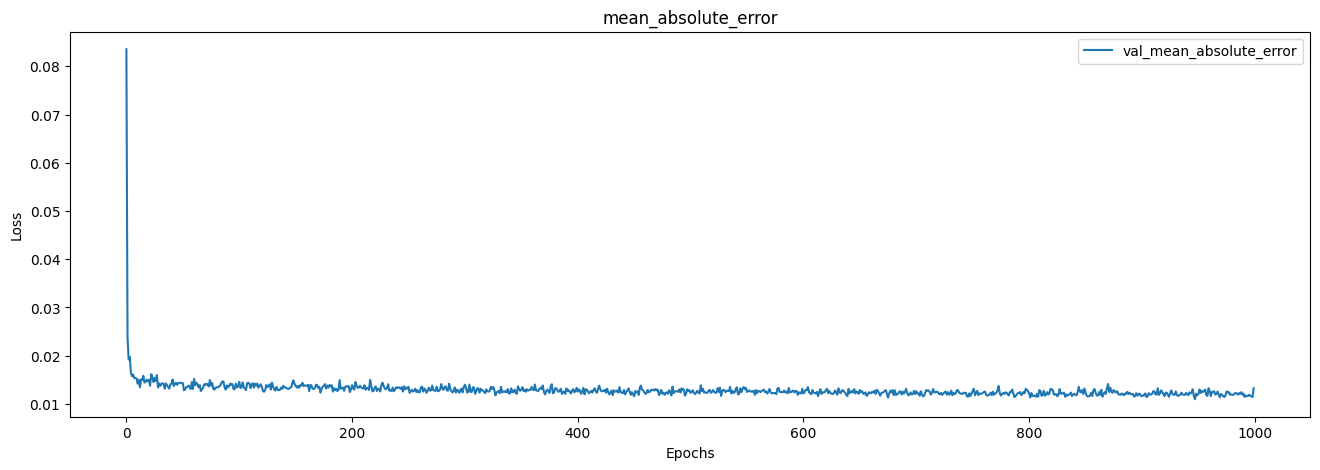

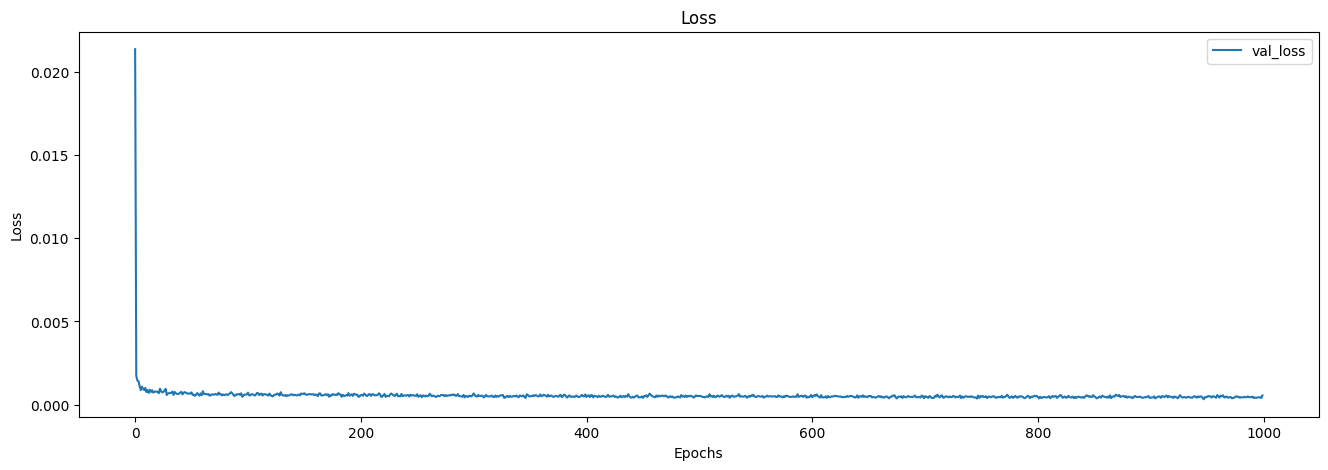

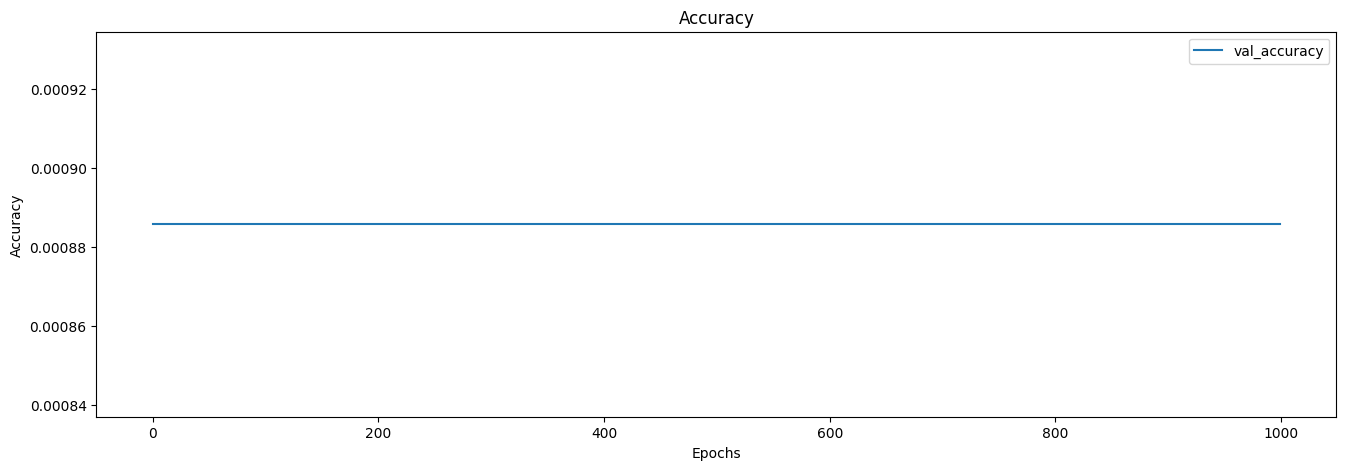

In [17]:
visualize_training_results(history)


In [18]:
# Evaluate the model on the test set
mse, accuracy, mae = model.evaluate(X_test, y_test)


18/18 [==============================] - 3s 7ms/step - loss: 6.3961e-04 - accuracy: 0.0035 - mean_absolute_error: 0.0173


In [19]:

# Step 8: Tuning the Hyperparameters
# You can use techniques such as grid search or random search to find the best values for the model's hyperparameters

# Step 9: Testing the model
y_pred = model.predict(X_test)
print('y_pred', y_pred.shape)
print('y_test', y_test.shape)

# convert to original data
y_pred = scaler.inverse_transform(y_pred)
y_test= scaler.inverse_transform(y_test)


# evaluat
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = 100 * np.mean(np.abs((y_test - y_pred) / y_test))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print("MAPE: {:.4f}%".format(mape))
print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))


18/18 [==============================] - 4s 6ms/step
y_pred (565, 1)
y_test (565, 1)
MAPE: 2.2541%
RMSE: 1309.5343
MSE: 1714880.0771
MAE:896.8924


In [20]:
y_pred

array([[40970.59 ],
       [41298.883],
       [39806.83 ],
       [39288.113],
       [37087.19 ],
       [36458.336],
       [35529.48 ],
       [33562.062],
       [32190.742],
       [34344.844],
       [34737.582],
       [33567.164],
       [32199.715],
       [34536.824],
       [35020.26 ],
       [36296.438],
       [35384.246],
       [34116.117],
       [33841.305],
       [34849.227],
       [35838.53 ],
       [34362.04 ],
       [34926.07 ],
       [34778.64 ],
       [33135.516],
       [33794.46 ],
       [33949.81 ],
       [34550.63 ],
       [33739.89 ],
       [32999.01 ],
       [32628.502],
       [32184.543],
       [31730.291],
       [31762.494],
       [32026.98 ],
       [31072.379],
       [30012.135],
       [31942.725],
       [32312.09 ],
       [33301.844],
       [34354.38 ],
       [35203.69 ],
       [38995.242],
       [38976.51 ],
       [40710.02 ],
       [40922.047],
       [41873.375],
       [42732.555],
       [41743.656],
       [40315.785],


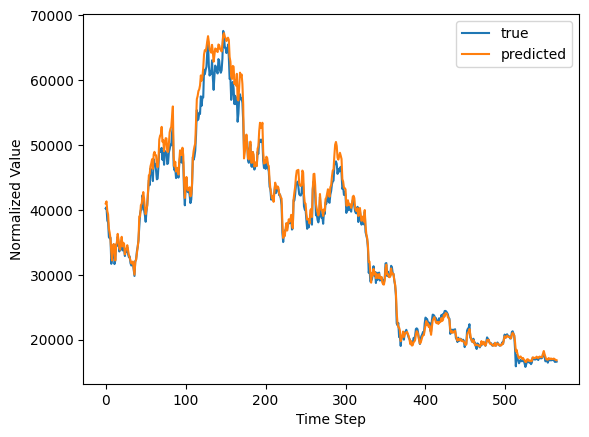

In [21]:

# plot the first sample in the test set
plt.plot(y_test, label='true')

# plot the corresponding predicted values
plt.plot(y_pred, label='predicted')

# set plot labels and legend
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()


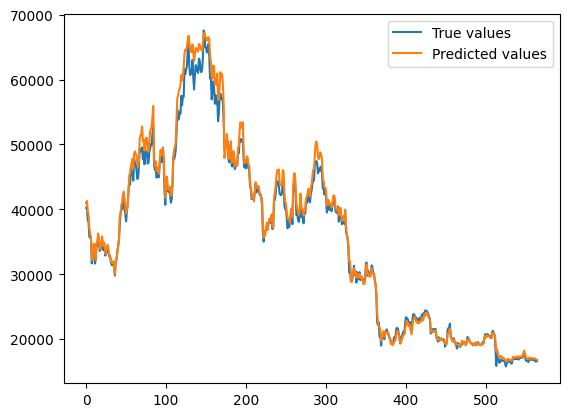

In [22]:
# Plot the true values and predicted values
plt.plot(y_test, label='True values')
plt.plot(y_pred, label='Predicted values')

# Add a legend and show the plot
plt.legend()
plt.show()


In [23]:
y_pred_df = pd.DataFrame(y_pred, columns=["Adj Close"])
y_test_df = pd.DataFrame(y_test, columns=["Adj Close"])

# Get the length of y_pred
y_pred_length = y_pred.shape[0]
y_test_length = y_test.shape[0]

# Generate dates for the next y_pred_length days يجب تعديل التاريخ اعتماداً على فترة الاختبار يجب ملاحظة ذلك 
today = pd.Timestamp.now().date()
prediction_dates = today - timedelta(days=y_pred_length-1)
test = today - timedelta(days=y_test_length-1)
prediction = pd.date_range(start=test_data.index[0], end=test_data.index[-1], freq='D')
test_dates = pd.date_range(start=test_data.index[0], end=test_data.index[-1], freq='D')

# Use the generated dates as the index of the DataFrame
y_pred_df['Date'] = prediction

y_test_df['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column
y_pred_df.set_index('Date', inplace=True)
y_test_df.set_index('Date', inplace=True)


# Assuming y_pred is a numpy array




In [24]:

y_test_df.to_csv("y_test_2021_2022.csv")
y_test_df

array([[40218.47656],
       [40406.26953],
       [38347.0625 ],
       [38053.50391],
       [35787.24609],
       [35615.87109],
       [35698.29688],
       [31676.69336],
       [32505.66016],
       [33723.02734],
       [34662.4375 ],
       [31637.7793 ],
       [32186.27734],
       [34649.64453],
       [34434.33594],
       [35867.77734],
       [35040.83594],
       [33572.11719],
       [33897.04688],
       [34668.54688],
       [35287.78125],
       [33746.00391],
       [34235.19531],
       [33855.32813],
       [32877.37109],
       [33798.01172],
       [33520.51953],
       [34240.1875 ],
       [33155.84766],
       [32702.02539],
       [32822.34766],
       [31780.73047],
       [31421.53906],
       [31533.06836],
       [31796.81055],
       [30817.83203],
       [29807.34766],
       [32110.69336],
       [32313.10547],
       [33581.55078],
       [34292.44531],
       [35350.1875 ],
       [37337.53516],
       [39406.94141],
       [39995.90625],
       [40

In [28]:
y_pred_df.to_csv("y_pred_2021_2022.csv")  # index=False to exclude index column in CSV
y_pred_df


,Adj Close
Date,
2021-06-14,40970.589844
2021-06-15,41298.882812
2021-06-16,39806.828125
2021-06-17,39288.113281
2021-06-18,37087.191406
...,...
2022-12-26,17067.093750
2022-12-27,17044.000000
2022-12-28,16921.574219


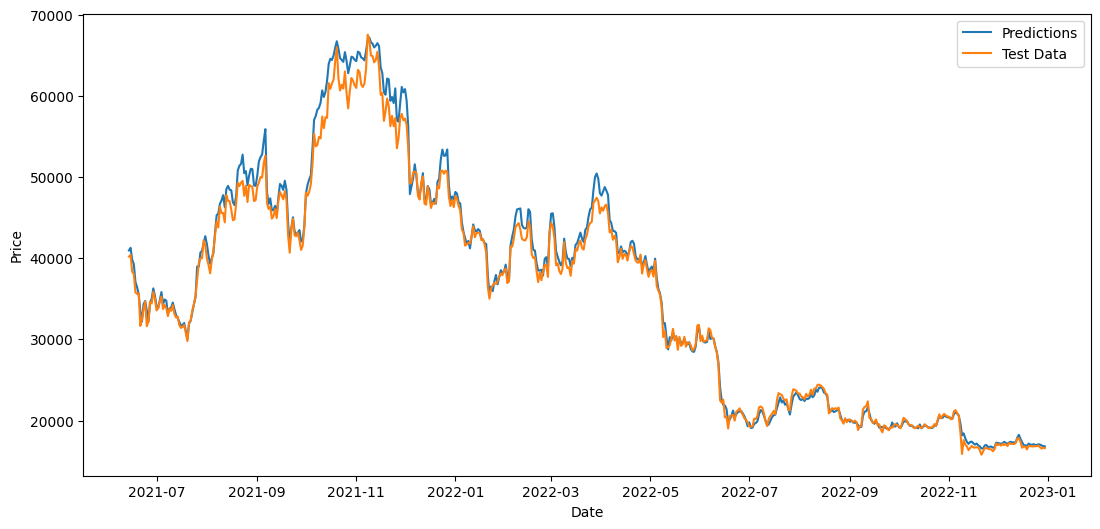

In [29]:
plt.figure(figsize=(13, 6))
plt.plot(y_pred_df, label='Predictions')
plt.plot(y_test_df, label='Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [30]:

names = cycle(['Predictions', 'Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_pred_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_test_df['Adj Close'], name='Test Data',
                         line=dict(width=2, color='red')))
fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()


In [31]:
# Calculate mean absolute percentage error (MAPE)
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))


mape_value = mape(y_test, y_pred)
print(f'MAPE: {mape_value:.4f}%')


MAPE: 2.2541%


In [32]:
def smape(y_true, y_pred):
    return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


SMAPE1 = smape(y_test, y_pred)
print("smape: {:.4f}%".format(SMAPE1))


smape: 2.2209%


In [35]:
future_data = data.iloc[-30:, :]
future_data = future_data.values
future_data = pd.DataFrame(future_data, columns=["Open", "High", "Low", "Adj Close", "Volume", "RSI",
                                                 "EMA_short", "EMA_long"])

# Get the length of future_data
future_length = future_data.shape[0]

# Generate dates for the next 30 days
today = pd.Timestamp.now().date()
future_dates = today + timedelta(days=1)

future = pd.date_range(start=future_dates, end=today +
                       timedelta(days=30), freq='D')

# Generate dates for the next 10 days for predict
today = pd.Timestamp.now().date()
future_dates_pred = pd.date_range(start=today, periods=10, freq='D')

# Use the generated dates as the index of the DataFrame
future_data['Date'] = future

# Set the index of the dataframes to be the 'Date' column
future_data.set_index('Date', inplace=True)

future_data.tail(10)
x_future_data = future_data.drop(['Adj Close'], axis=1).values
y_future_data = future_data['Adj Close'].values
y_future_data = y_future_data.reshape(-1, 1)

print("x_future_data:", x_future_data.shape)
print("y_future_data:", y_future_data.shape)

# x_future_data= np.reshape(x_future_data, (x_future_data.shape[0], 1, x_future_data.shape[1]))

print("x_future_data:", x_future_data.shape)
x_future_data = scaler.fit_transform(x_future_data)
y_future_data = scaler.fit_transform(y_future_data)
for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]
    # future_data_temp = future_data_temp.reshape(-1, 1)
    print("future_data_temp", future_data_temp.shape)


x_future_data: (30, 7)
y_future_data: (30, 1)
x_future_data: (30, 7)
future_data_temp (30, 7)
future_data_temp (29, 7)
future_data_temp (28, 7)
future_data_temp (27, 7)
future_data_temp (26, 7)
future_data_temp (25, 7)
future_data_temp (24, 7)
future_data_temp (23, 7)
future_data_temp (22, 7)
future_data_temp (21, 7)


In [36]:

# Initialize a numpy array to store the predictions
prediction = np.zeros((10, 1))

for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]

    print("future_data_temp1", future_data_temp.shape)
    future_data_temp = np.reshape(future_data_temp, (future_data_temp.shape[0],
                                                     1, future_data_temp.shape[1]))
    pred = model.predict(future_data_temp)
    print("future_data_temp2", future_data_temp.shape)
    print('---------------------------------------------------')
    prediction[i][0] = pred[0][0]
    x_future_data[i+future_data_temp.shape[0]-1][0] = pred[0][0]
print('3', future_data.shape)
print('prediction:', prediction.shape)
# Reverse the MinMaxScaler
y_future_data = y_future_data.reshape(-1, 1)
y_future_data = scaler.inverse_transform(y_future_data)
prediction = scaler.inverse_transform(prediction)

# Create a new dataframe with the predicted values and the dates as the index
prediction_df = pd.DataFrame(
    prediction, index=future_dates_pred, columns=['Adj Close'])
print('y_future_data', y_future_data.shape)
# Get the length of future_data

y_future_data = pd.DataFrame(y_future_data,  columns=['Adj Close'])

future_length = future_data.shape[0]
test = today - timedelta(days=future_length-1)
test_dates = pd.date_range(start=test, end=today, freq='D')
# Use the generated dates as the index of the DataFrame


y_future_data['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column

y_future_data.set_index('Date', inplace=True)


future_data_temp1 (30, 7)
1/1 [==============================] - 0s 63ms/step
future_data_temp2 (30, 1, 7)
---------------------------------------------------
future_data_temp1 (29, 7)
1/1 [==============================] - 0s 81ms/step
future_data_temp2 (29, 1, 7)
---------------------------------------------------
future_data_temp1 (28, 7)
1/1 [==============================] - 0s 50ms/step
future_data_temp2 (28, 1, 7)
---------------------------------------------------
future_data_temp1 (27, 7)
1/1 [==============================] - 0s 68ms/step
future_data_temp2 (27, 1, 7)
---------------------------------------------------
future_data_temp1 (26, 7)
1/1 [==============================] - 0s 45ms/step
future_data_temp2 (26, 1, 7)
---------------------------------------------------
future_data_temp1 (25, 7)
1/1 [==============================] - 0s 63ms/step
future_data_temp2 (25, 1, 7)
---------------------------------------------------
future_data_temp1 (24, 7)
1/1 [===============

In [37]:
prediction_df


,Adj Close
2023-02-23,22624.479197
2023-02-24,22579.312880
2023-02-25,22953.464504
2023-02-26,22898.359716
2023-02-27,22954.300421
2023-02-28,23013.474172
2023-03-01,23468.721956
2023-03-02,23057.002278
2023-03-03,23092.297558
2023-03-04,23396.177134


In [38]:
y_future_data


,Adj Close
Date,
2023-01-25,22934.431641
2023-01-26,22636.468750
2023-01-27,23117.859375
2023-01-28,23032.777344
2023-01-29,23078.728516
2023-01-30,23031.089844
2023-01-31,23774.566406
2023-02-01,22840.138672
2023-02-02,23139.283203


In [1]:
names = cycle(['Predictions next 10 day', 'Actual data '])

fig = go.Figure()

fig.add_trace(go.Scatter(x=y_future_data.index, y=y_future_data['Adj Close'], name='Actual data ',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='blue')))

fig.add_shape(type='line',
              x0=prediction_df.index[-1], y0=prediction_df.index[-1],
              x1=y_future_data.index[0], y1=y_future_data[0],
              line=dict(color='grey', width=2, dash='dot'))
fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()


NameError: name 'cycle' is not defined

In [40]:
actual_x = y_future_data.index
actual_y = y_future_data['Adj Close']
pred_x = prediction_df.index
pred_y = prediction_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=actual_x, y=actual_y, name='Actual Data'))
fig.add_trace(go.Scatter(x=pred_x, y=pred_y,
              name='Predictions Data for 10 day'))

fig.add_shape(type='line',
              x0=actual_x[-1], y0=actual_y[-1],
              x1=pred_x[0], y1=pred_y[0],
              line=dict(color='grey', width=2, dash='dot'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='predict next 10 day '
)

fig.show()


In [41]:
names = cycle(['Predictions', 'Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_pred_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_test_df['Adj Close'], name='Test Data',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='blue')))
fig.add_shape(type='line',
              x0=prediction_df.index[-1], y0=prediction_df[-1],
              x1=y_pred_df.index[0], y1=y_pred_df[0],
              line=dict(color='grey', width=2, dash='dot'))

fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()
